# Model Training Notebook

This notebook allows training of smaller POC Models. The architecture can be adjusted inside of the notebook. The logic matches the logic of `src.vae_pipeline.py`.

In [1]:
import vae.vae_base as vae_base
import numpy as np
from vae.vae_utils import (
    instantiate_vae_model,
    train_vae,
    save_vae_model,
    get_posterior_samples,
    get_prior_samples,
    load_vae_model,
)
from data_utils import (
    load_yaml_file,
    load_data,
    split_data,
    scale_data,
    inverse_transform_data,
    save_scaler,
    save_data,
)
import paths
from vae.vae_base import BaseVariationalAutoencoder, Sampling
from model_saving import append_row_to_csv
import pandas as pd
import tensorflow as tf
import joblib
from tensorflow.keras.layers import (
    Conv1D,
    Flatten,
    Dense,
    Conv1DTranspose,
    Reshape,
    Input,
    GlobalAvgPool1D,
    Cropping1D,
    ZeroPadding1D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, TimeDistributed, RepeatVector, GlobalAveragePooling1D
import os
import time
import matplotlib.pyplot as plt
import pickle
import visualize

In [2]:
dataset_name = "jerkEventSubset_20"

In [3]:
data = load_data(data_dir=paths.DATASETS_DIR, dataset=dataset_name)

# split data into train/valid splits
train_data, valid_data = split_data(data, valid_perc=0.1, shuffle=True)

# scale data
scaled_train_data, scaled_valid_data, scaler = scale_data(train_data, valid_data)

In [4]:

class VariationalAutoencoderPOC(BaseVariationalAutoencoder):
    model_name = "VAE_POC"

    def __init__(self, hidden_layer_sizes, **kwargs):
        super(VariationalAutoencoderPOC, self).__init__(**kwargs)

        if hidden_layer_sizes is None:
            hidden_layer_sizes = [50, 100, 200]

        self.hidden_layer_sizes = hidden_layer_sizes
        self.encoder = self._get_encoder()
        self.decoder = self._get_decoder()
        self.compile(optimizer=Adam())

    def _get_encoder(self):
        encoder_inputs = Input(
            shape=(self.seq_len, self.feat_dim), name="encoder_input"
        )
        x = encoder_inputs
        
        x = Bidirectional(LSTM(64, return_sequences=False), name="bidirectional_lstm")(x)
        # save the dimensionality of this last dense layer before the hidden state layer. We need it in the decoder.
        self.encoder_last_dense_dim = x.shape[-1]

        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)

        encoder_output = Sampling()([z_mean, z_log_var])
        self.encoder_output = encoder_output

        encoder = Model(
            encoder_inputs, [z_mean, z_log_var, encoder_output], name="encoder"
        )
        # encoder.summary()
        return encoder

    def _get_decoder(self):
        decoder_inputs = Input(shape=(self.latent_dim,), name="decoder_input")

        # Project and repeat latent vector over time
        x = Dense(self.encoder_last_dense_dim, activation="relu", name="dec_dense")(decoder_inputs)
        x = RepeatVector(self.seq_len, name="dec_repeat")(x)  # shape: (B, seq_len, D)

        # Replace Conv1DTranspose stack with one BiLSTM
        x = Bidirectional(
            LSTM(units=self.hidden_layer_sizes[-1], return_sequences=True, activation="tanh"),
            name="dec_bilstm"
        )(x)

        # Final projection per time step
        x = TimeDistributed(Dense(self.feat_dim), name="dec_output_projection")(x)

        self.decoder_outputs = x
        decoder = Model(decoder_inputs, self.decoder_outputs, name="decoder")
        return decoder

    @classmethod
    def load(cls, model_dir) -> "VariationalAutoencoderPOC":
        params_file = os.path.join(model_dir, f"{cls.model_name}_parameters.pkl")
        dict_params = joblib.load(params_file)
        vae_model = VariationalAutoencoderPOC(**dict_params)
        vae_model.load_weights(model_dir)
        vae_model.compile(optimizer=Adam())
        return vae_model


In [5]:
# Instantiate and train the VAE Model
vae_type = "vae_POC"
model_id = f"{vae_type}_{dataset_name}_{int(time.time())}"


# load hyperparameters from yaml file
config = load_yaml_file(paths.HYPERPARAMETERS_FILE_PATH)
hyperparameters = config[vae_type]

# instantiate the model
_, sequence_length, feature_dim = scaled_train_data.shape

batch_size = hyperparameters["batch_size"]

vae = VariationalAutoencoderPOC(
    model_id=model_id,
    seq_len=sequence_length,
    feat_dim=feature_dim,
    **hyperparameters,
)

In [6]:
config["common"]["max_epochs"]

200

In [7]:
vae.fit_on_data(scaled_train_data[:2000], config["common"]["max_epochs"], True)

Epoch 1/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - kl_loss: 15.8963 - loss: 58.5684 - reconstruction_loss: 58.5684 - reconstruction_wt: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 310.4373 - loss: 7.6031 - reconstruction_loss: 7.6031 - reconstruction_wt: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - kl_loss: 1051.7861 - loss: 5.8580 - reconstruction_loss: 5.8580 - reconstruction_wt: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - kl_loss: 1446.4020 - loss: 5.2388 - reconstruction_loss: 5.2388 - reconstruction_wt: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 1707.4817 - loss: 4.7848 - reconstruction_loss: 4.7848 - reconstruction_wt: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/200
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - kl_loss: 2091.0447 - loss: 4.5725 - reconstruction_loss: 4.5725 -

In [8]:
def load_history(pkl_path):
    with open(pkl_path, "rb") as f:
        history = pickle.load(f)
    return history

def moving_avg(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def evaluate_training_run(history, plot=True):
    results = {}
    
    # Extract metrics
    loss = np.array(history["loss"])
    kl = np.array(history["kl_loss"])
    recon = np.array(history["reconstruction_loss"])
    lr = np.array(history["learning_rate"])
    wt = np.array(history["reconstruction_wt"]) if "reconstruction_wt" in history else np.ones_like(loss)

    # === Plotting (Optional) ===
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        metrics = [loss, kl, recon, lr]
        names = ["Loss", "KL Loss", "Recon Loss", "Learning Rate"]

        for ax, metric, name in zip(axs.flat, metrics, names):
            ax.plot(metric, label=name)
            ax.set_title(name)
            ax.set_xlabel("Epoch")
            ax.grid(True)
            ax.legend()

        plt.tight_layout()
        plt.show()

    # === 1. Plateau Detection ===
    def has_plateau(metric, window=10, tol=1e-3):
        tail = moving_avg(metric, w=window)
        deltas = np.abs(np.diff(tail))
        return np.all(deltas[-window:] < tol)

    results["loss_plateau"] = has_plateau(loss)
    results["kl_plateau"] = has_plateau(kl)
    results["recon_plateau"] = has_plateau(recon)

    # === 2. KL Collapse ===
    results["kl_collapse"] = np.mean(kl[-10:]) < 1e-3

    # === 3. Overfitting Heuristic ===
    recon_grad = np.gradient(recon)
    kl_grad = np.gradient(kl)
    results["possible_overfit"] = recon_grad[-1] > -1e-3 and kl_grad[-1] > 0.01


    # === 5. Learning Rate Too High or Low ===
    results["lr_final"] = lr[-1]
    results["lr_stable"] = np.std(lr[-10:]) < 1e-6 or np.allclose(lr[-1], lr[0])

    # === 6. General Convergence Score (0–1) ===
    stability_score = 1.0
    if results["kl_collapse"]: stability_score -= 0.3
    if results["possible_overfit"]: stability_score -= 0.2
    if not results["loss_plateau"]: stability_score -= 0.2
    results["stability_score"] = round(max(0.0, stability_score), 3)

    return results


Notes on runs: 

- vae_POC 1753185366: Using unscaled data seems to reduce the problem of having collapsing LR? (But we also used a smaller dataset so we will test with a scaed small subset of data and adjust accordingly)

------------ RUN id vae_POC_jerkEventSubset_20_1753292953_trainingHistory.pkl------------


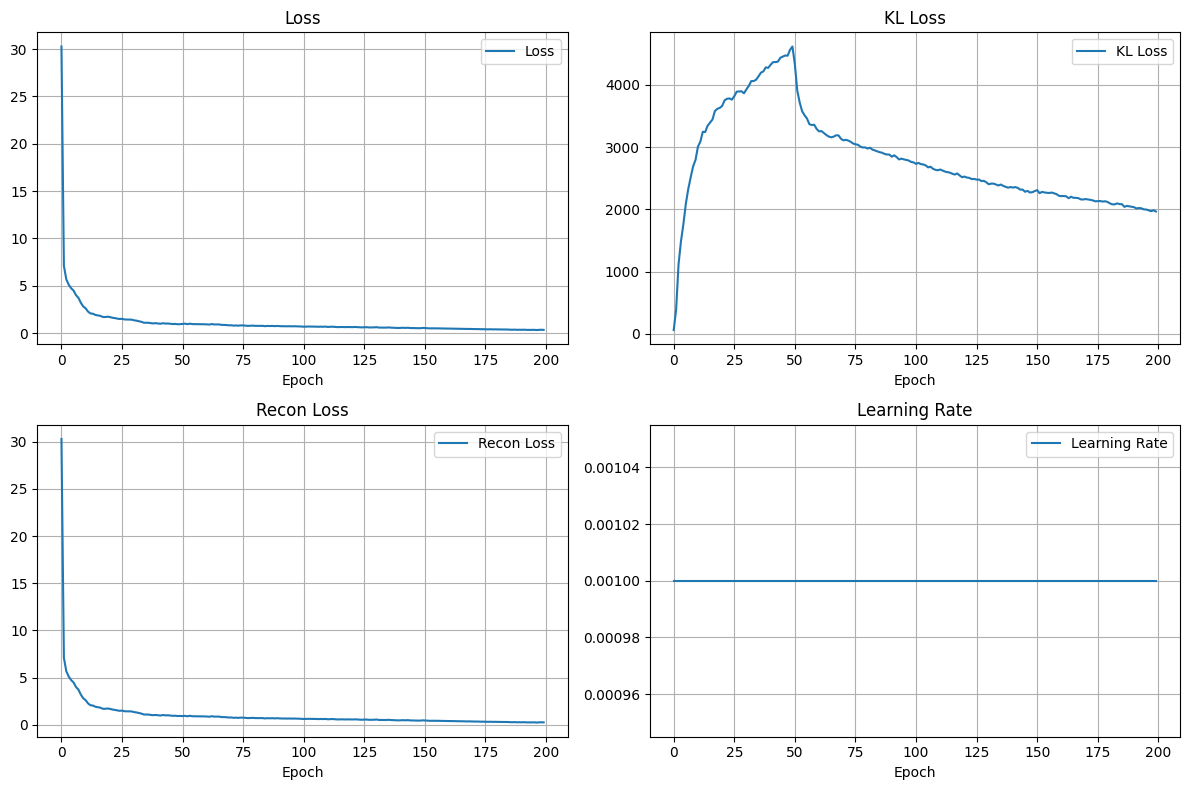

{'loss_plateau': False,
 'kl_plateau': False,
 'recon_plateau': False,
 'kl_collapse': False,
 'possible_overfit': False,
 'lr_final': 0.0010000000474974513,
 'lr_stable': True,
 'stability_score': 0.8}

In [9]:
# Load history and and tsne
last_run = [path for path in os.listdir(".") if path.startswith("vae_POC")][-3]
with open(last_run, "rb") as f:
    history = pickle.load(f)
print(f"------------ RUN id {last_run}------------")
evaluate_training_run(history)


In [10]:
# ----------------------------------------------------------------------------------
# Save scaler and model
model_save_dir = os.path.join(paths.MODELS_DIR, dataset_name, model_id)
# save scaler
save_scaler(scaler=scaler, dir_path=model_save_dir)
# Save vae
save_vae_model(vae=vae, dir_path=model_save_dir)
# Add model with parameters to the model list
model_params = {
    "model_id": model_id,
    "model_type": vae_type,
    "dataset_name": dataset_name,
    "date": time.strftime("%Y-%m-%d"),
    }

for key, value in hyperparameters.items():
    if isinstance(value, list):
        model_params[key] = [value]
    else:
        model_params[key] = value
for key, value in config["common"].items():
    model_params[key] = value

current_model = pd.DataFrame(model_params, index=[0])
append_row_to_csv(current_model, paths.MODEL_LIST_PATH)

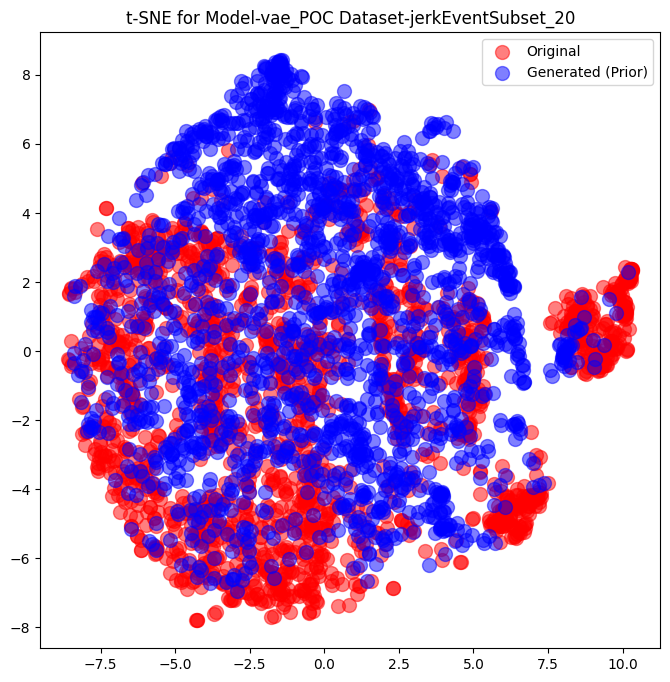

In [11]:
prior_samples = get_prior_samples(vae, num_samples=train_data.shape[0])

visualize.visualize_and_save_tsne(
    samples1=scaled_train_data,
    samples1_name="Original",
    samples2=prior_samples,
    samples2_name="Generated (Prior)",
    scenario_name=f"Model-{vae_type} Dataset-{dataset_name}",
    save_dir=os.path.join(paths.TSNE_DIR, dataset_name, model_id),
    max_samples=2000,
)

In [12]:
x = scaled_train_data[:16,:,:]

In [13]:
z_mean, z_log_var, output = vae.encoder(x)

In [14]:
z_mean

<tf.Tensor: shape=(16, 64), dtype=float32, numpy=
array([[ 0.07902163,  0.7862857 , -0.18738504, ..., -0.2658232 ,
         0.03974831, -0.20387147],
       [-0.01328789,  0.3649701 , -0.01094714, ...,  0.03476565,
        -0.12831973,  0.07431152],
       [-0.06014002,  0.0227438 , -0.10668007, ...,  0.12310716,
        -0.42167482, -0.7401325 ],
       ...,
       [ 0.11975773,  0.18564062,  0.09275545, ...,  0.31247455,
         0.09248852,  0.04023844],
       [-0.00719182,  0.29022002,  0.89499694, ...,  0.9977559 ,
        -0.01094544, -0.46002704],
       [ 0.09078751,  0.74599206,  0.29554644, ...,  0.3834416 ,
        -0.02034744, -0.04534007]], dtype=float32)>

In [15]:
z_mu, z_logvar, z = vae.encoder(inputs=x[1,:,:])

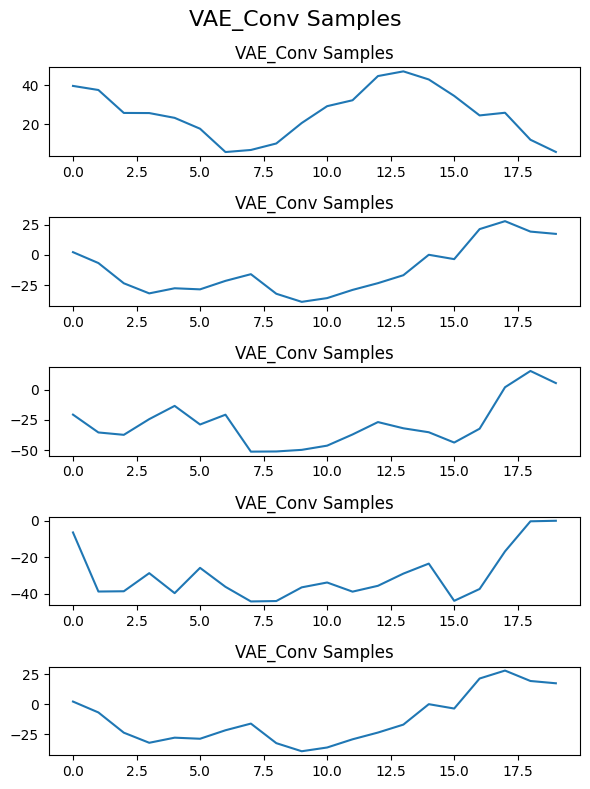

In [16]:
samples = vae.get_prior_samples(num_samples=5)
samples = scaler.inverse_transform(samples)
visualize.plot_samples(
    samples1=samples,
    samples1_name="VAE_Conv Samples",
    num_samples=5
)